# Notebook 1: Protocolo de Extracción de Datos y Preparación del Dataset (Sampling)
## Proyecto: Evaluación de Riesgo Arqueológico mediante Machine Learning
**Caso de Estudio:** Modelo Predictivo de Probabilidad de Hallazgos en el Territorio Peruano

**Autor:** Yishar Piero Nieto Barrientos  
**Repositorio de Investigación:** [Tu enlace de GitHub aquí]

---

### **Introducción**
Este notebook constituye la fase inicial del flujo de trabajo de **Ingeniería de Características (Feature Engineering)** aplicado a la arqueología preventiva[cite: 7]. El objetivo central es la transformación de datos geoespaciales continuos (Rasters) en una estructura de datos tabular (Dataframe) apta para algoritmos de aprendizaje supervisado[cite: 48, 58].

Mediante la técnica de **"Pixel Drilling"** o muestreo puntual multivariable, se extraen los valores de variables biofísicas y culturales en coordenadas específicas[cite: 50, 57]. Este proceso permite que el modelo identifique patrones de asentamiento basados en la habitabilidad y la proximidad a recursos estratégicos[cite: 19, 20].

### **Especificaciones Técnicas**
* **Resolución Espacial:** 30 x 30 metros por píxel, asegurando un balance entre precisión geográfica y eficiencia computacional.
* **Estrategia de Optimización:** Pre-cálculo de distancias euclidianas y variables derivadas en entorno GIS (Rasterización previa) para acelerar la inferencia en Python[cite: 4, 5, 6].
* **Variables Predictoras:** Topografía (Pendiente, Rugosidad), Hidrografía (Ríos, Lagos) y Redes Culturales (Qhapaq Ñan, Sitios Declarados)[cite: 21, 24, 28, 35, 39].

### **1. Instalacion de librerias**
Instalamos las librerías necesarias para el manejo de rasters y modelos predictivos.

In [41]:
import os
import sys
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import rasterio

from shapely.geometry import Point

# Esto es para que los mapas se vean bonitos dentro del notebook
%matplotlib inline

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


### **2. Inventario de Variables y Fuentes de Datos**
Para garantizar la validez del modelo predictivo, se han seleccionado variables que responden a criterios de habitabilidad, acceso a recursos y conectividad arqueológica. Cada capa ha sido procesada con una resolución de 30 metros.

| Categoría | Capa Raster (.tif) | Descripción Técnica | Justificación Arqueológica |
| :--- | :--- | :--- | :--- |
| **Topografía** | `pendiente_calca.tif` | Inclinación del terreno en grados. | Define áreas aptas para construcción y agricultura. |
| **Topografía** | `rugosidad_calca.tif` | Índice de Rugosidad del Terreno (TRI). | Identifica la complejidad del relieve y transitabilidad. |
| **Hidrografía**| `dis_rios_calca.tif` | Distancia euclidiana a redes hídricas. | Recurso vital para el sustento y comunicación. |
| **Hidrografía**| `dis_lagos_calca.tif` | Distancia a cuerpos hídricos lénticos. | Zonas de captación de recursos y posible carácter ritual. |
| **Cultura** | `dis_qhapaq.tif` | Proximidad a la red vial incaica. | Eje de articulación territorial y hallazgos asociados |
| **Evidencia** | `dis_declarados.tif` | Distancia a sitios arqueológicos registrados. | Probabilidad aumentada por recurrencia de ocupación. |

In [42]:
# Lista de archivos basada en tu tabla de variables
archivos_raster = [
    '../data/processed/raster_pendiente.tif',
    '../data/processed/raster_rugosidad.tif',
    '../data/processed/dis_lagos_calca.tif',
    '../data/processed/dis_qhapaq.tif',
    '../data/processed/dis_declarados.tif',
    '../data/processed/dis_g1.tif',
    '../data/processed/dis_g2.tif',
    '../data/processed/dis_g3.tif'
]

print("--- Verificando Fuentes de Datos Geoespaciales ---")
for ruta in archivos_raster:
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            # Validamos que la resolución sea de 30m como dice tu texto
            res_x, res_y = src.res
            print(f" {os.path.basename(ruta)} | Res: {res_x}m | CRS: {src.crs}")
    else:
        print(f"ADVERTENCIA: No se encontró el archivo en: {ruta}")

--- Verificando Fuentes de Datos Geoespaciales ---
 raster_pendiente.tif | Res: 30.0m | CRS: EPSG:32719
 raster_rugosidad.tif | Res: 30.0m | CRS: EPSG:32719
 dis_lagos_calca.tif | Res: 30.0m | CRS: EPSG:32719
 dis_qhapaq.tif | Res: 30.0m | CRS: EPSG:32719
 dis_declarados.tif | Res: 30.0m | CRS: EPSG:32719
 dis_g1.tif | Res: 30.0m | CRS: EPSG:32719
 dis_g2.tif | Res: 30.0m | CRS: EPSG:32719
 dis_g3.tif | Res: 30.0m | CRS: EPSG:32719


#### **2.1 Visualizacion y validacion de capas topograficas**
Realizamos una carga ligera de cada variable para confirmar su integridad estructural y espacial antes del procesamiento masivo.

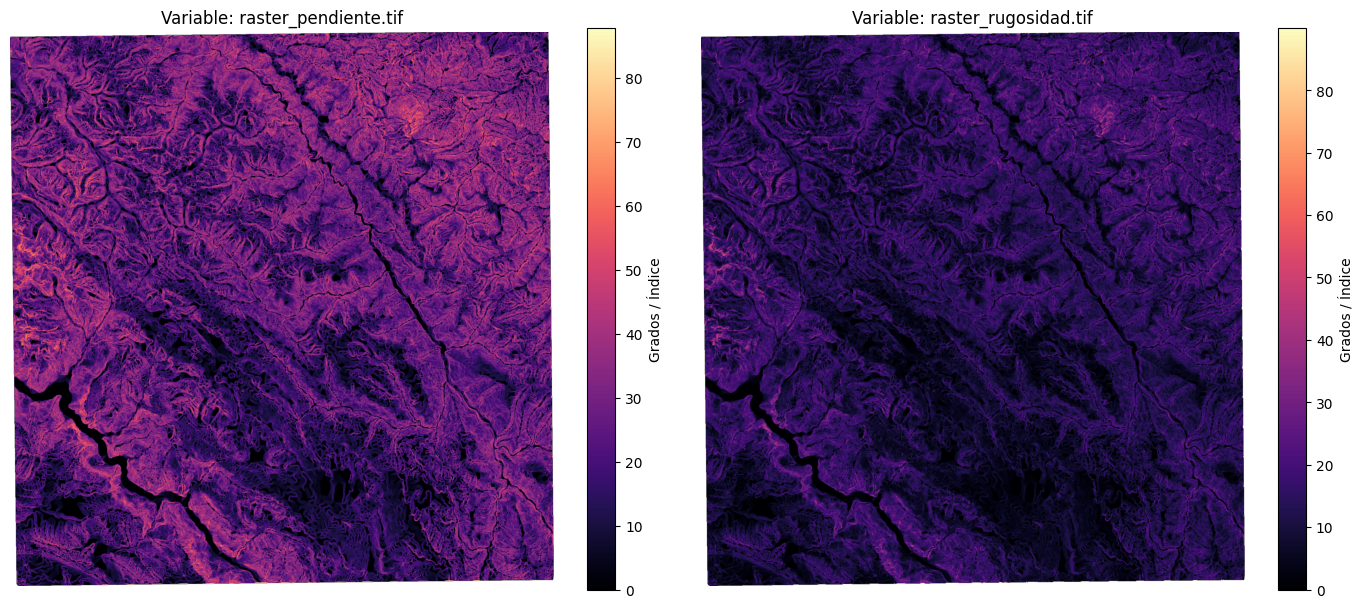

In [43]:
# Definimos las capas topográficas
capas_topografia = ['../data/processed/raster_pendiente.tif', '../data/processed/raster_rugosidad.tif']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, ruta in enumerate(capas_topografia):
    with rasterio.open(ruta) as src:
        data = src.read(1)
        # Filtramos valores fuera de rango para recuperar el relieve
        data_filtrada = np.where((data < 0) | (data > 90), np.nan, data)
        
        im = axes[i].imshow(data_filtrada, cmap='magma')
        plt.colorbar(im, ax=axes[i], label='Grados / Índice')
        axes[i].set_title(f"Variable: {os.path.basename(ruta)}")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

#### **2.2 Visualizacion y validacion de capas de distancia**
Se representan las distancias euclidianas hacia recursos hídricos y elementos culturales. El gradiente Viridis muestra la proximidad: los tonos oscuros indican cercanía inmediata, facilitando la identificación de zonas con mayor potencial de conectividad y recursos.

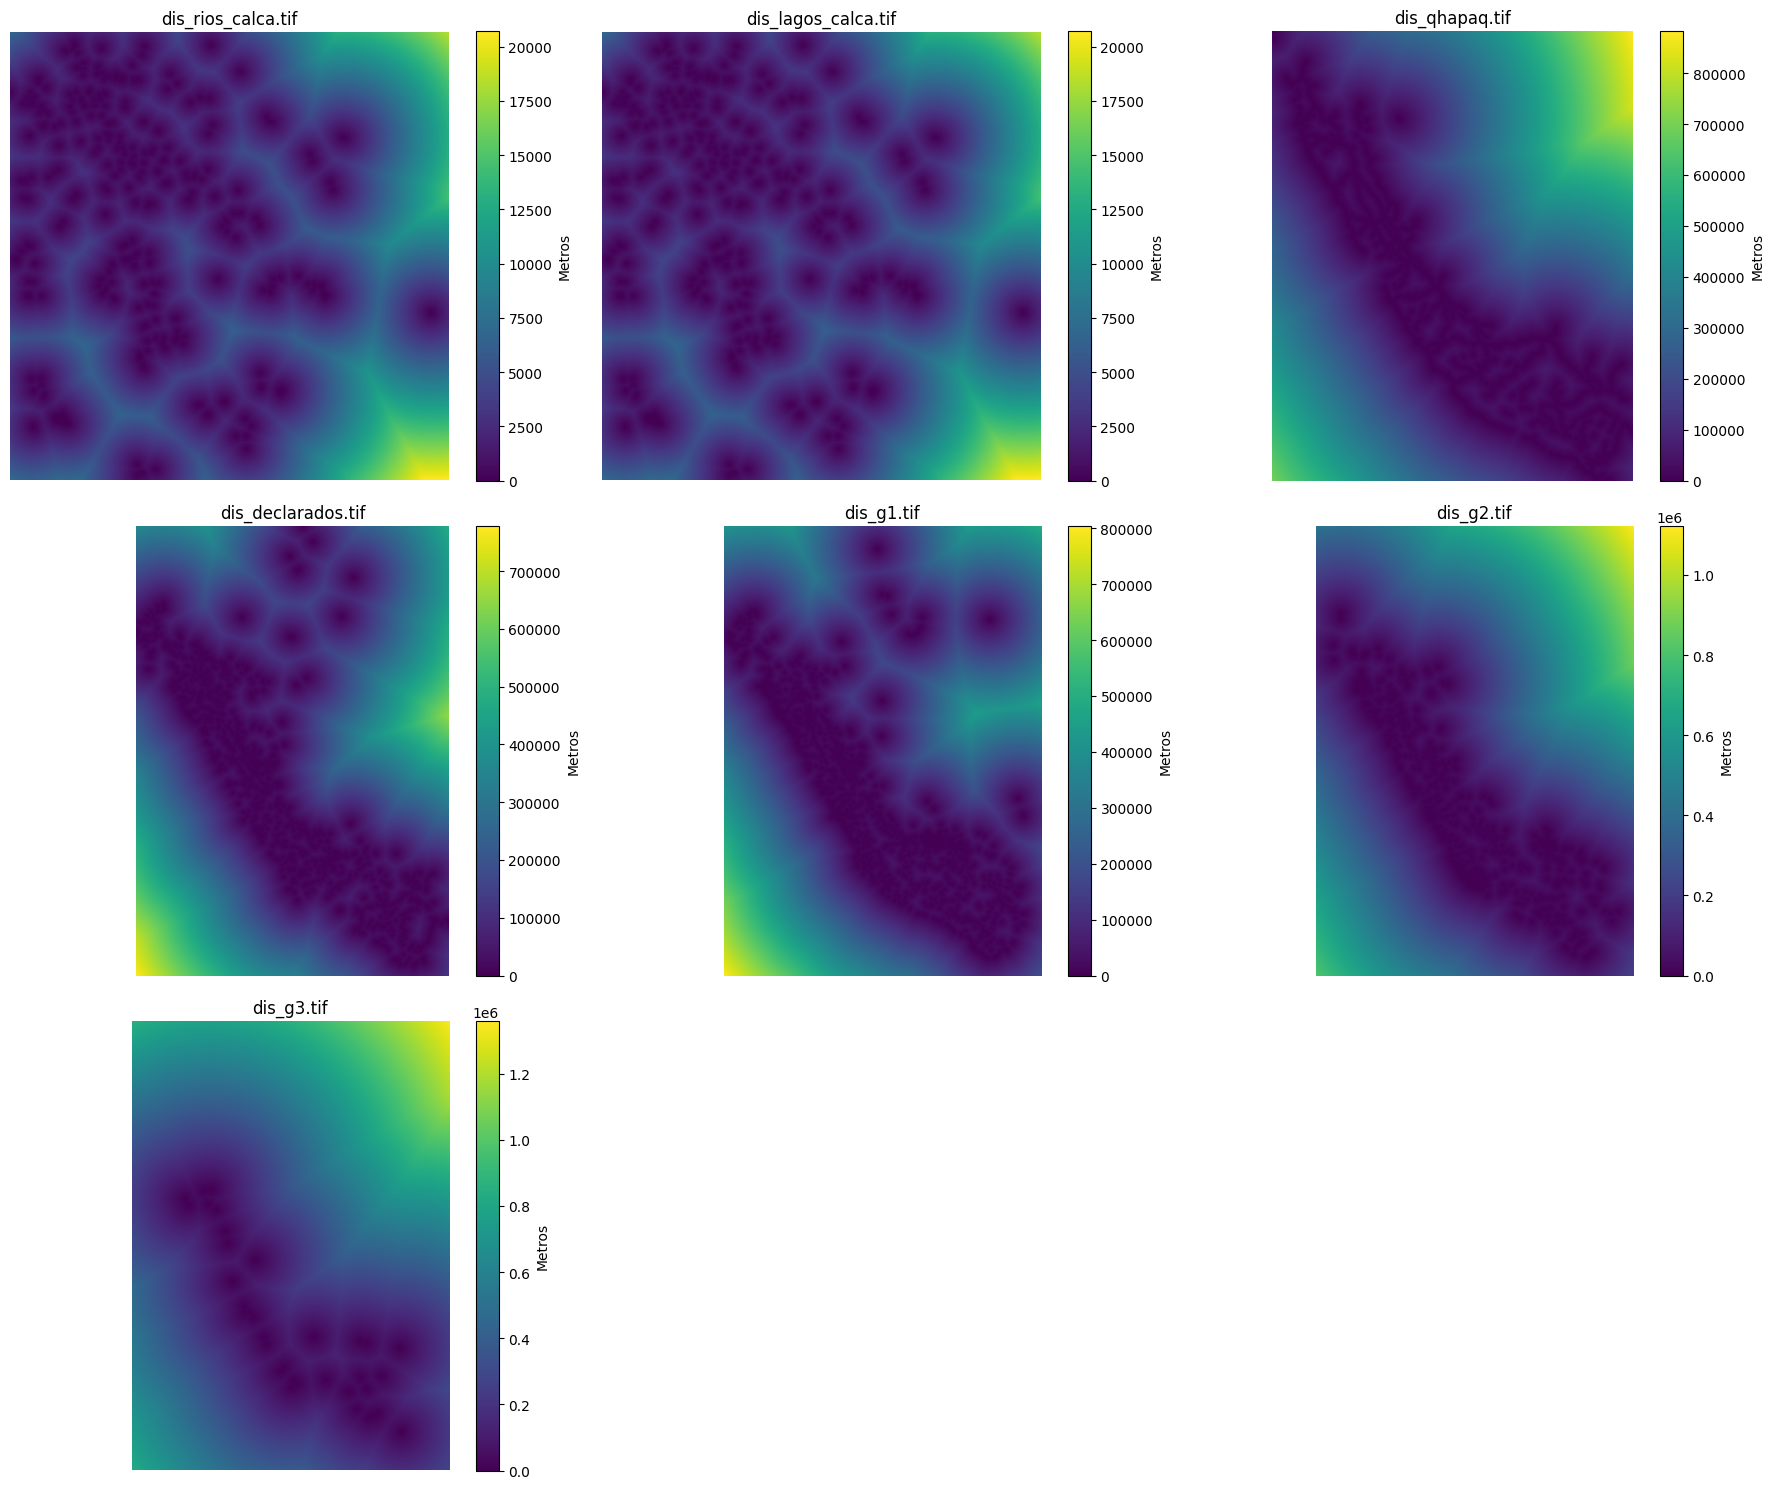

In [44]:
# Lista actualizada con los 7 archivos
capas_distancia = [
    '../data/processed/dis_rios_calca.tif', '../data/processed/dis_lagos_calca.tif',
    '../data/processed/dis_qhapaq.tif', '../data/processed/dis_declarados.tif',
    '../data/processed/dis_g1.tif', '../data/processed/dis_g2.tif', '../data/processed/dis_g3.tif'
]

# Ajustamos a 3x3 para que quepan los 7 (sobrarán 2 espacios)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, ruta in enumerate(capas_distancia):
    with rasterio.open(ruta) as src:
        # Lectura al 10% para proteger la RAM de los 58GB
        data = src.read(1, out_shape=(1, int(src.height // 10), int(src.width // 10)))
        
        im = axes[i].imshow(data, cmap='viridis')
        plt.colorbar(im, ax=axes[i], label='Metros')
        axes[i].set_title(os.path.basename(ruta))
        axes[i].axis('off')

# Ocultamos los cuadros que sobraron (el 8 y el 9)
for j in range(len(capas_distancia), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### **3. Preprocesamiento: Armonizacion de proyecciones CRS**

In [45]:
#Pendiente

### **4. Analisis Exploratorio de datos (EDA)**
En esta etapa, transformamos los datos espaciales en datos estadísticos. Dado que manejamos un volumen de 58 GB, utilizaremos un muestreo aleatorio sistemático para obtener una representación estadísticamente significativa sin agotar los recursos de memoria RAM.

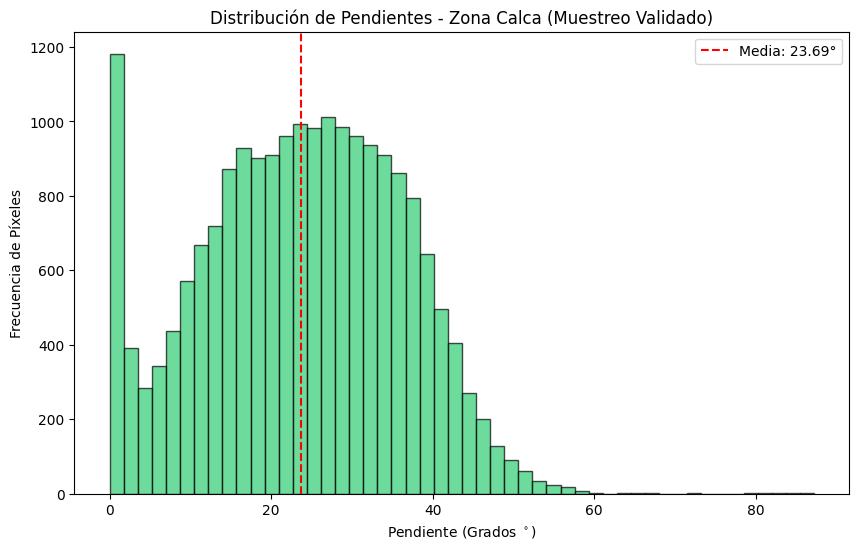

In [46]:
ruta_pendiente = '../data/processed/raster_pendiente.tif'

def muestreo_inteligente(ruta, n_puntos=20000):
    with rasterio.open(ruta) as src:
        # Obtenemos los límites que acabamos de diagnosticar
        l, b, r, t = src.bounds
        muestras_validas = []
        
        # Intentamos capturar puntos hasta llenar nuestra cuota de n_puntos
        intentos = 0
        while len(muestras_validas) < n_puntos and intentos < n_puntos * 5:
            # Generamos coordenadas aleatorias REALES dentro de la extensión
            x_rand = np.random.uniform(l, r)
            y_rand = np.random.uniform(b, t)
            
            # Muestreamos el valor en esa coordenada geográfica
            for val in src.sample([(x_rand, y_rand)]):
                # Filtramos el NoData (-9999.0) y valores incoherentes
                if val[0] != -9999.0 and 0 <= val[0] <= 90:
                    muestras_validas.append(val[0])
            intentos += 1
            
        return muestras_validas

# Extraemos los datos con puntería láser
datos_pendiente = muestreo_inteligente(ruta_pendiente)

# Graficamos el Histograma Final
plt.figure(figsize=(10, 6))
# Usamos r'' para evitar el SyntaxWarning del \c
plt.hist(datos_pendiente, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)

media = np.mean(datos_pendiente)
plt.axvline(media, color='red', linestyle='dashed', label=f'Media: {media:.2f}°')

plt.title('Distribución de Pendientes - Zona Calca (Muestreo Validado)')
plt.xlabel(r'Pendiente (Grados $^\circ$)')
plt.ylabel('Frecuencia de Píxeles')
plt.legend()
plt.show()

Iniciando muestreo estratificado de 5000 píxeles...
Muestreo finalizado. Puntos válidos: 5000


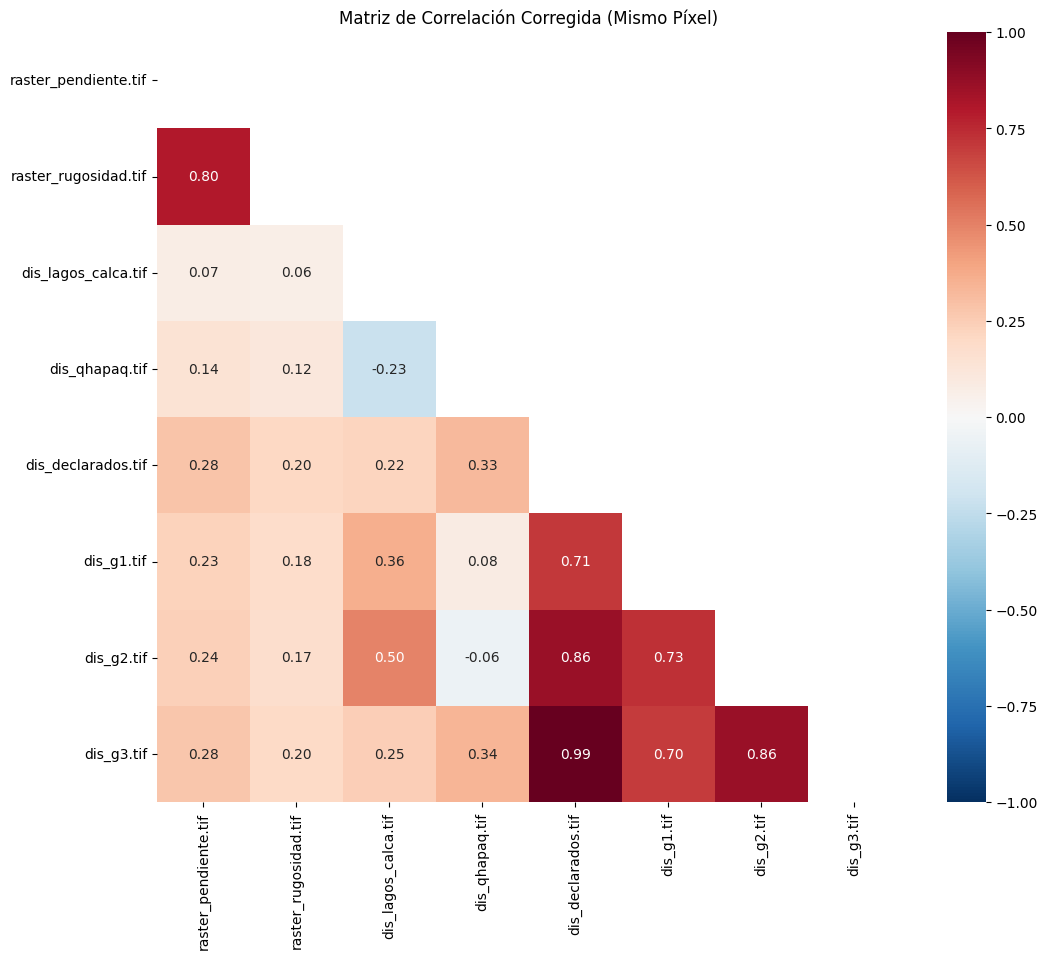

In [47]:
# ==========================================
# CORRECCIÓN DE LA LÓGICA DE MUESTREO (STACK)
# ==========================================

def muestreo_multicapa(lista_rutas, n_puntos=10000):
    """
    Extrae valores de múltiples rasters en LAS MISMAS coordenadas.
    Esencial para análisis de correlación y entrenamiento de modelos.
    """
    data_matrix = []
    nombres_cols = [os.path.basename(r) for r in lista_rutas]
    
    # Abrimos todos los rasters a la vez
    src_files = [rasterio.open(r) for r in lista_rutas]
    
    # Usamos los límites del primer raster como referencia (el DEM)
    # Asumimos que todos están alineados (fase de pre-procesamiento)
    l, b, r, t = src_files[0].bounds
    
    puntos_recolectados = 0
    max_intentos = n_puntos * 50
    intentos = 0
    
    print(f"Iniciando muestreo estratificado de {n_puntos} píxeles...")
    
    while puntos_recolectados < n_puntos and intentos < max_intentos:
        # Generamos 1 coordenada aleatoria
        x_rand = np.random.uniform(l, r)
        y_rand = np.random.uniform(b, t)
        
        # Extraemos el valor de esa coordenada en TODAS las capas
        fila_valores = []
        valido = True
        
        for src in src_files:
            # sample devuelve un generador, tomamos el primer valor
            val = list(src.sample([(x_rand, y_rand)]))[0][0]
            
            # Validacion estricta: Si CUALQUIER capa tiene NoData, descartamos el punto entero
            # Ajusta -9999 si tus rasters de distancia usan otro valor de fondo
            if val == -9999.0 or np.isnan(val) or val < -1000: 
                valido = False
                break
            fila_valores.append(val)
            
        if valido:
            data_matrix.append(fila_valores)
            puntos_recolectados += 1
            
        intentos += 1

    # Cerramos los archivos
    for src in src_files:
        src.close()
        
    print(f"Muestreo finalizado. Puntos válidos: {len(data_matrix)}")
    return pd.DataFrame(data_matrix, columns=nombres_cols)

# --- EJECUCIÓN ---
# Generamos el dataset corregido
df_analisis = muestreo_multicapa(archivos_raster, n_puntos=5000)

# Verificamos la correlación de nuevo
plt.figure(figsize=(12, 10))
matriz_corr = df_analisis.corr()

# Máscara para ocultar la mitad superior repetida
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))

sns.heatmap(matriz_corr, mask=mask, annot=True, cmap='RdBu_r', center=0, fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación Corregida (Mismo Píxel)')
plt.show()

### **5. Construcción de la Variable Dependiente (Target Variable)**

Para entrenar modelos de aprendizaje supervisado, se define una variable objetivo binaria ($Y$) que representa la probabilidad de ocurrencia de sitios arqueológicos.

#### **5.1 Procesamiento y Homogeneización de Presencias**

La evidencia arqueológica positiva ($Y=1$) proviene de dos fuentes vectoriales con geometrías distintas (Puntos y Polígonos). El procesamiento de estos datos sigue un protocolo estricto de alineación espacial y muestreo:

1.  **Estandarización del Sistema de Coordenadas (CRS):**
    Los datos originales se encuentran en el sistema geográfico WGS84 (EPSG:4326). Para garantizar la compatibilidad con las variables predictoras (Rasters) y permitir cálculos de distancia euclidiana precisos, se realiza una **reproyección vectorial** al sistema proyectado **UTM Zona 19S (EPSG:32719)**. Esto unifica la unidad de medida en metros.

2.  **Estrategia de Muestreo Estratificado (Mitigación de Sesgo):**
    Para evitar el sesgo por área (*Area Bias*) provocado por la disparidad de tamaños entre sitios:
    * **Sitios Puntuales (Declarados):** Se integran como observaciones únicas.
    * **Sitios Poligonales (Delimitados):** Se aplica un algoritmo de muestreo interno que genera puntos aleatorios proporcionales al área, con un **límite máximo (*Cap*) de 50 muestras** por sitio. Esto asegura que los grandes complejos no sobrerrepresenten la variabilidad ambiental en el dataset de entrenamiento.

--- INICIANDO PROCESAMIENTO DE PRESENCIAS (5.1) ---

1. Cargando Polígonos: delimitados.shp
   [INFO] Reproyectando de EPSG:4326 a EPSG:32719...
  > Muestreando 10665 polígonos (en metros)...
   > Polígonos listos: 100818 muestras generadas.

2. Cargando Puntos: declarados.shp
   [INFO] Reproyectando de EPSG:4326 a EPSG:32719...
   > Puntos listos: 5890 registros.

DATASET DE PRESENCIAS (Y=1) GENERADO EN UTM 19S
Total de Muestras: 106708


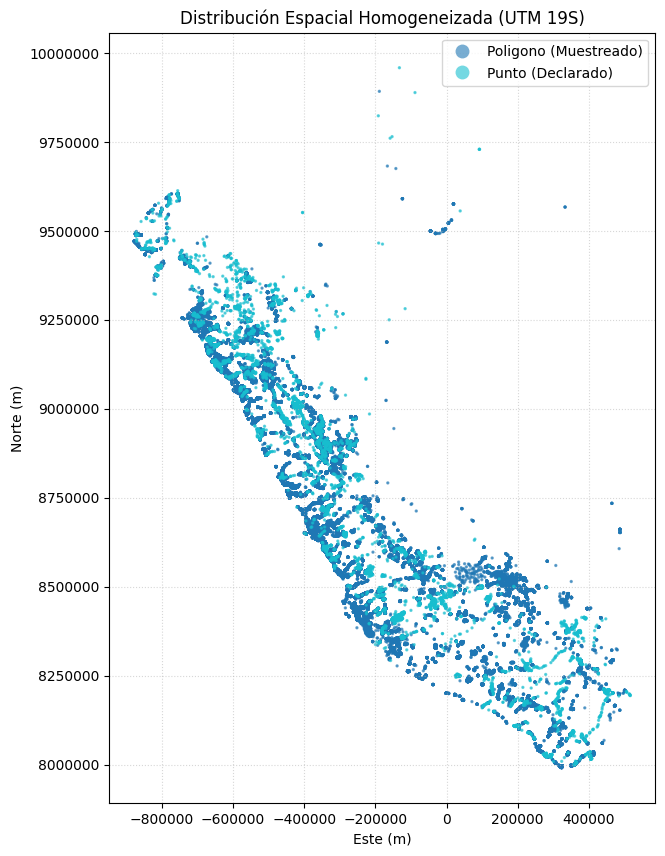

In [48]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os

# ==========================================
# 1. CONFIGURACIÓN Y PARÁMETROS
# ==========================================
# CRS Objetivo: UTM Zona 19S (Metros)
EPSG_OBJETIVO = 32719 

# Parámetros de Muestreo (Calibrados para 30m)
AREA_PIXEL = 900              # 30m x 30m
DENSIDAD_MUESTREO = 10        # 1 punto cada 10 píxeles teóricos
MAX_PUNTOS_POR_POLIGONO = 50  # CAP: Tope máximo por sitio

# Rutas de Archivos (Ajusta si es necesario)
ruta_poligonos = '../data/raw/delimitados.shp'
ruta_puntos = '../data/raw/declarados.shp'

# ==========================================
# 2. FUNCIÓN DE MUESTREO (Sobre datos ya reproyectados)
# ==========================================
def muestreo_inteligente_poligonos(gdf, max_puntos):
    muestras = []
    print(f"  > Muestreando {len(gdf)} polígonos (en metros)...")
    
    for idx, row in gdf.iterrows():
        poly = row.geometry
        if poly is None or poly.is_empty: continue
        
        # Como ya estamos en UTM, poly.area nos da METROS CUADRADOS reales
        n_teorico = int(poly.area / (AREA_PIXEL * DENSIDAD_MUESTREO))
        n_final = max(1, min(n_teorico, max_puntos))
        
        puntos_hit = []
        minx, miny, maxx, maxy = poly.bounds
        intentos = 0
        
        while len(puntos_hit) < n_final and intentos < n_final * 20:
            x = np.random.uniform(minx, maxx)
            y = np.random.uniform(miny, maxy)
            pnt = Point(x, y)
            
            if poly.contains(pnt):
                puntos_hit.append({
                    'geometry': pnt,
                    'origen': 'Poligono (Muestreado)',
                    'clase': 1
                })
            intentos += 1
        muestras.extend(puntos_hit)
        
    return gpd.GeoDataFrame(muestras, crs=gdf.crs)

# ==========================================
# 3. FLUJO DE EJECUCIÓN (CARGA -> REPROYECCIÓN -> PROCESO)
# ==========================================
dataframes_list = []

print("--- INICIANDO PROCESAMIENTO DE PRESENCIAS (5.1) ---")

# A) Procesar POLÍGONOS
if os.path.exists(ruta_poligonos):
    print(f"\n1. Cargando Polígonos: {os.path.basename(ruta_poligonos)}")
    gdf_poly = gpd.read_file(ruta_poligonos)
    
    # REPROYECCIÓN CRÍTICA
    if gdf_poly.crs.to_string() != f"EPSG:{EPSG_OBJETIVO}":
        print(f"   [INFO] Reproyectando de {gdf_poly.crs} a EPSG:{EPSG_OBJETIVO}...")
        gdf_poly = gdf_poly.to_crs(epsg=EPSG_OBJETIVO)
    
    # Aplicamos muestreo sobre los datos ya convertidos a metros
    gdf_muestras = muestreo_inteligente_poligonos(gdf_poly, MAX_PUNTOS_POR_POLIGONO)
    dataframes_list.append(gdf_muestras)
    print(f"   > Polígonos listos: {len(gdf_muestras)} muestras generadas.")
else:
    print(f"[ALERTA] No se encontró: {ruta_poligonos}")

# B) Procesar PUNTOS
if os.path.exists(ruta_puntos):
    print(f"\n2. Cargando Puntos: {os.path.basename(ruta_puntos)}")
    gdf_pts = gpd.read_file(ruta_puntos)
    
    # REPROYECCIÓN CRÍTICA
    if gdf_pts.crs.to_string() != f"EPSG:{EPSG_OBJETIVO}":
        print(f"   [INFO] Reproyectando de {gdf_pts.crs} a EPSG:{EPSG_OBJETIVO}...")
        gdf_pts = gdf_pts.to_crs(epsg=EPSG_OBJETIVO)
        
    temp_pts = gdf_pts[['geometry']].copy()
    temp_pts['origen'] = 'Punto (Declarado)'
    temp_pts['clase'] = 1
    dataframes_list.append(temp_pts)
    print(f"   > Puntos listos: {len(temp_pts)} registros.")
else:
    print(f"[ALERTA] No se encontró: {ruta_puntos}")

# ==========================================
# 4. CONSOLIDACIÓN Y VISUALIZACIÓN
# ==========================================
if dataframes_list:
    gdf_presencias = pd.concat(dataframes_list, ignore_index=True)
    
    print("\n" + "="*50)
    print(f"DATASET DE PRESENCIAS (Y=1) GENERADO EN UTM 19S")
    print(f"Total de Muestras: {len(gdf_presencias)}")
    print("="*50)
    
    # Mapa de Control
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_presencias.plot(ax=ax, column='origen', markersize=2, alpha=0.6, legend=True)
    
    # Ajustes estéticos (Ahora sí funcionarán porque son metros)
    plt.title("Distribución Espacial Homogeneizada (UTM 19S)")
    plt.xlabel("Este (m)")
    plt.ylabel("Norte (m)")
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.ticklabel_format(style='plain') # Para ver los números completos
    plt.show()

else:
    print("[ERROR] No hay datos para procesar.")

#### **5.2 Generación de Pseudo-Ausencias (Background Points)**

En el modelado de distribución de especies (SDM) y arqueología predictiva, los registros suelen ser de tipo "Solo-Presencia". Para entrenar clasificadores binarios como Random Forest, es indispensable generar una clase de contraste ($Y=0$) que represente la disponibilidad ambiental del territorio.

Se implementa la generación de **Pseudo-Ausencias** (*Pseudo-absences*) bajo un diseño experimental riguroso:

1.  **Espacio de Muestreo (UTM 19S):** Los puntos se generan aleatoriamente dentro de los límites definidos por las variables raster (área de estudio), asegurando que cada punto tenga valores ambientales válidos.
2.  **Criterio de Exclusión (Buffer):** Se aplica una restricción espacial de **500 metros** alrededor de todos los sitios arqueológicos confirmados (Presencias). Esto minimiza la probabilidad de "Falsos Negativos" (etiquetar como ausencia un área aledaña a un sitio que podría contener vestigios no excavados).
3.  **Balanceo de Clases (Ratio 1:1):** Se genera un número de ausencias equivalente al total de presencias ($n \approx 16,000$), garantizando un dataset balanceado que previene el sesgo del algoritmo hacia la clase mayoritaria.

Área de estudio definida por Raster: BoundingBox(left=174542.27, bottom=8505581.6, right=229382.27, top=8561531.6)

Generando 106708 puntos de ausencia...
  > Calculando zona de exclusión (Buffer 500m)...


/tmp/ipykernel_2589/3846952335.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  zona_prohibida = gdf_prohibido.geometry.buffer(buffer_dist).unary_union


  > Iniciando muestreo aleatorio (Rejection Sampling)...
    Progreso: 9579 / 106708...
    Progreso: 19103 / 106708...
    Progreso: 28711 / 106708...
    Progreso: 38280 / 106708...
    Progreso: 47837 / 106708...
    Progreso: 57394 / 106708...
    Progreso: 66935 / 106708...
    Progreso: 76491 / 106708...
    Progreso: 86060 / 106708...
    Progreso: 95623 / 106708...
    Progreso: 105200 / 106708...

DATASET DE ENTRENAMIENTO FINALIZADO
Presencias (Clase 1): 106708
Ausencias  (Clase 0): 106708
TOTAL MUESTRAS:       213416


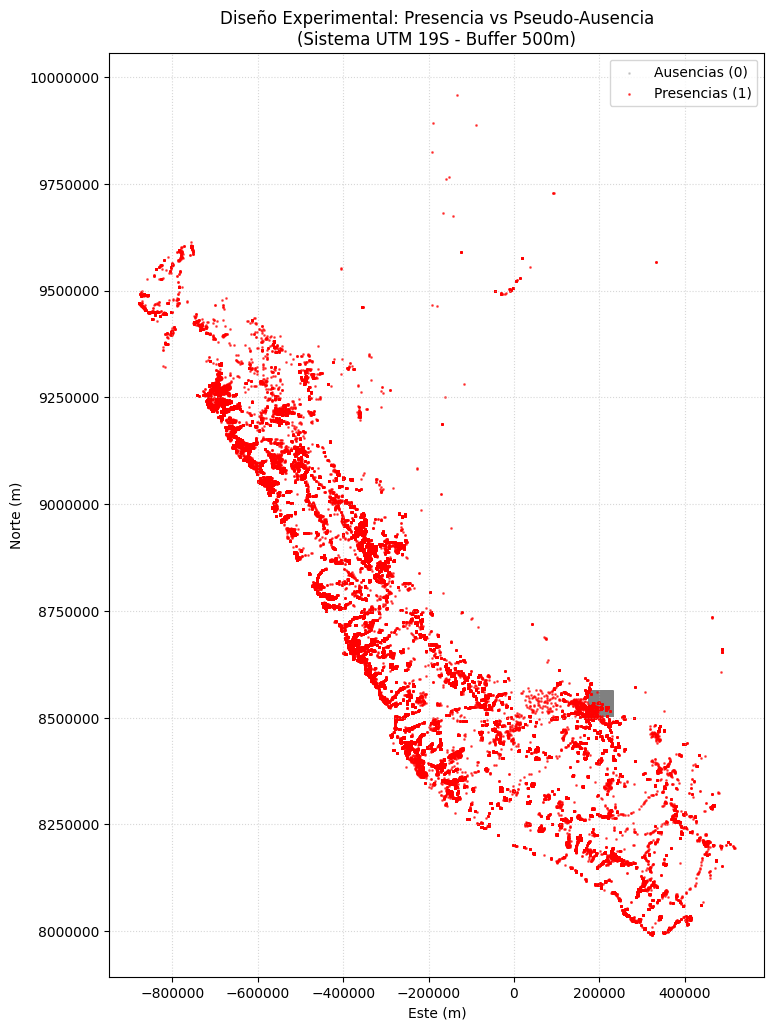

In [49]:
# ==========================================
# 1. PARÁMETROS DEL DISEÑO EXPERIMENTAL
# ==========================================
BUFFER_SEGURIDAD = 500  # 500 metros reales (gracias a que ya estamos en UTM)
RATIO_AUSENCIAS = 1     # 1:1 (Misma cantidad que presencias)

# Raster de referencia para obtener los límites exactos del área de estudio
# (Asegúrate que este archivo exista de tus pasos anteriores)
ruta_referencia = '../data/processed/raster_pendiente.tif'

# ==========================================
# 2. DEFINICIÓN DEL ÁREA DE ESTUDIO
# ==========================================
try:
    with rasterio.open(ruta_referencia) as src:
        bounds = src.bounds # (left, bottom, right, top) en UTM
        crs_raster = src.crs
    print(f"Área de estudio definida por Raster: {bounds}")
except:
    print("[AVISO] No se encontró raster de referencia. Usando extensión ('bounding box') de los sitios.")
    bounds = gdf_presencias.total_bounds

# ==========================================
# 3. ALGORITMO GENERADOR DE AUSENCIAS
# ==========================================
def generar_ausencias_seguras(n_requeridos, area_bounds, gdf_prohibido, buffer_dist):
    ausencias = []
    minx, miny, maxx, maxy = area_bounds
    
    print(f"\nGenerando {n_requeridos} puntos de ausencia...")
    print(f"  > Calculando zona de exclusión (Buffer {buffer_dist}m)...")
    
    # Fusión geométrica (Unary Union): Crea una sola "mancha" prohibida
    # Esto es mucho más rápido que comparar punto por punto
    zona_prohibida = gdf_prohibido.geometry.buffer(buffer_dist).unary_union
    
    print("  > Iniciando muestreo aleatorio (Rejection Sampling)...")
    intentos = 0
    
    while len(ausencias) < n_requeridos:
        # Generamos lotes grandes para eficiencia
        lote_size = 2000
        xs = np.random.uniform(minx, maxx, lote_size)
        ys = np.random.uniform(miny, maxy, lote_size)
        
        for x, y in zip(xs, ys):
            pnt = Point(x, y)
            
            # CRITERIO DE ACEPTACIÓN:
            # El punto NO debe tocar la zona prohibida
            if not zona_prohibida.contains(pnt):
                ausencias.append({
                    'geometry': pnt,
                    'origen': 'Pseudo-Ausencia',
                    'clase': 0
                })
                
                if len(ausencias) >= n_requeridos:
                    break
        
        intentos += 1
        if intentos % 5 == 0:
            print(f"    Progreso: {len(ausencias)} / {n_requeridos}...")
            
    return gpd.GeoDataFrame(ausencias, crs=gdf_prohibido.crs)

# ==========================================
# 4. EJECUCIÓN Y CONSOLIDACIÓN
# ==========================================

# Calculamos cuántas ausencias necesitamos
n_presencias = len(gdf_presencias)
n_ausencias_objetivo = int(n_presencias * RATIO_AUSENCIAS)

# Ejecutamos el generador
gdf_ausencias = generar_ausencias_seguras(
    n_ausencias_objetivo, 
    bounds, 
    gdf_presencias, 
    BUFFER_SEGURIDAD
)

# Unimos todo en el DATASET DE ENTRENAMIENTO FINAL (TRAIN SET)
gdf_final_train = pd.concat([gdf_presencias, gdf_ausencias], ignore_index=True)

print("\n" + "="*50)
print(f"DATASET DE ENTRENAMIENTO FINALIZADO")
print(f"Presencias (Clase 1): {n_presencias}")
print(f"Ausencias  (Clase 0): {len(gdf_ausencias)}")
print(f"TOTAL MUESTRAS:       {len(gdf_final_train)}")
print("="*50)

# ==========================================
# 5. VISUALIZACIÓN DEL DISEÑO
# ==========================================
fig, ax = plt.subplots(figsize=(12, 12))

# Capa 0: Ausencias (Gris de fondo)
gdf_ausencias.plot(ax=ax, color='gray', markersize=1, alpha=0.3, label='Ausencias (0)')

# Capa 1: Presencias (Rojo encima)
gdf_presencias.plot(ax=ax, color='red', markersize=1, alpha=0.6, label='Presencias (1)')

plt.title(f"Diseño Experimental: Presencia vs Pseudo-Ausencia\n(Sistema UTM 19S - Buffer {BUFFER_SEGURIDAD}m)")
plt.xlabel("Este (m)")
plt.ylabel("Norte (m)")
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.5)
plt.ticklabel_format(style='plain') # Números completos
plt.show()